In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance

In [2]:
start_date = '2016-02-01'
end_date = '2019-12-31'

In [3]:
data = yfinance.download("AUDUSD=X CADUSD=X CHFUSD=X \
                          CNYUSD=X DKKUSD=X EURUSD=X \
                          GBPUSD=X HKDUSD=X JPYUSD=X \
                          KZTUSD=X NOKUSD=X NZDUSD=X \
                          PLNUSD=X RUBUSD=X SEKUSD=X",
                        start=start_date)

[*********************100%***********************]  15 of 15 completed


In [4]:
data['Close'].head()

AUDUSD=X  CADUSD=X  CHFUSD=X  CNYUSD=X  DKKUSD=X  EURUSD=X  \
Date                                                                     
2016-02-01  0.706864  0.715676  0.976086  0.152297  0.145087  1.082591   
2016-02-02  0.711086  0.716846  0.980873  0.152244  0.146036  1.089728   
2016-02-03  0.702988  0.711238  0.981653  0.152212  0.146354  1.092204   
2016-02-04  0.715461  0.724942  0.994827  0.152277  0.148637  1.109102   
2016-02-05  0.719942  0.726998  1.006654  0.152560  0.150071  1.119996   

            GBPUSD=X  HKDUSD=X  JPYUSD=X  KZTUSD=X  NOKUSD=X  NZDUSD=X  \
Date                                                                     
2016-02-01  1.424603  0.128481  0.008241  0.002743  0.115135  0.646998   
2016-02-02  1.442793  0.128553  0.008275  0.002805  0.115201  0.654579   
2016-02-03  1.440922  0.128317  0.008343  0.002683  0.114683  0.652018   
2016-02-04  1.458576  0.128345  0.008466  0.002762  0.116773  0.664717   
2016-02-05  1.458109  0.128403  0.008557  0.002772  0.117701  0.672993   

            PLNUSD=X  RUBUSD=X  SEKUSD=X  
Date                                      
2016-02-01  0.245228  0.013256  0.116426  
2016-02-02  0.247986  0.012943  0.117306  
2016-02-03  0.248004  0.012545  0.116964  
2016-02-04  0.251062  0.012999  0.118491  
2016-02-05  0.253291  0.013026  0.119067

In [5]:
new_data = data['Close'].interpolate(method='polynomial', order=3)

In [24]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [8]:
values = new_data.values

In [9]:
values

array([[0.70686364, 0.71567619, 0.9760859 , ..., 0.24522787, 0.01325557,
        0.11642582],
       [0.71108586, 0.71684587, 0.98087299, ..., 0.24798575, 0.01294331,
        0.11730605],
       [0.70298767, 0.71123755, 0.98165292, ..., 0.24800359, 0.01254469,
        0.1169644 ],
       ...,
       [0.63907564, 0.70607007, 1.02543068, ..., 0.23744395, 0.01342913,
        0.10153171],
       [0.65033036, 0.71584523, 1.02780211, ..., 0.23819958, 0.01353387,
        0.10196975],
       [0.6487146 , 0.71324134, 1.028193  , ..., 0.23713596, 0.01358917,
        0.10130788]])

In [10]:
values.shape

(1113, 15)

In [11]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:
scaled

array([[0.55844355, 0.19041109, 0.0439291 , ..., 0.17284441, 0.15977478,
        0.6502564 ],
       [0.57622886, 0.19899893, 0.0861063 , ..., 0.21361399, 0.10419703,
        0.6780021 ],
       [0.54211664, 0.15782404, 0.09297752, ..., 0.21387768, 0.03324866,
        0.667233  ],
       ...,
       [0.27289796, 0.11988544, 0.47869015, ..., 0.05777526, 0.19066644,
        0.18078065],
       [0.32030654, 0.1916523 , 0.49958324, ..., 0.06894541, 0.20930862,
        0.19458795],
       [0.3135004 , 0.17253494, 0.5030279 , ..., 0.05322218, 0.21915197,
        0.17372537]], dtype=float32)

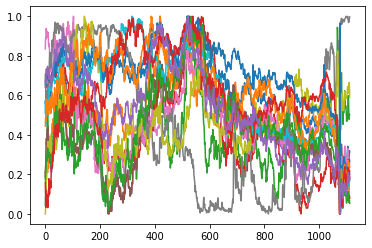

In [13]:
plt.plot(scaled)
plt.show()

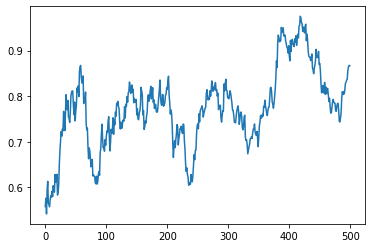

In [14]:
plt.plot(scaled[:,0][0:500])

In [57]:
# specify the number of lag hours
n_hours = 60
n_features = 15
n_predict = 15
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_predict)
print(reframed.shape)

(1039, 1125)


In [58]:
reframed.head()

var1(t-60)  var2(t-60)  var3(t-60)  var4(t-60)  var5(t-60)  var6(t-60)  \
60    0.558444    0.190411    0.043929    0.641567    0.187778    0.205439   
61    0.576229    0.198999    0.086106    0.638932    0.221347    0.239113   
62    0.542117    0.157824    0.092978    0.637329    0.232592    0.250793   
63    0.594659    0.258441    0.209049    0.640536    0.313314    0.330521   
64    0.613536    0.273531    0.313253    0.654541    0.363995    0.381919   

    var7(t-60)  var8(t-60)  var9(t-60)  var10(t-60)  ...  var6(t+14)  \
60    0.835093    0.668243    0.000000     0.510468  ...    0.465422   
61    0.890299    0.711098    0.019286     0.568661  ...    0.437115   
62    0.884620    0.569199    0.057711     0.453698  ...    0.436692   
63    0.938199    0.586304    0.127063     0.528093  ...    0.436692   
64    0.936779    0.620956    0.178442     0.538190  ...    0.392772   

    var7(t+14)  var8(t+14)  var9(t+14)  var10(t+14)  var11(t+14)  var12(t+14)  \
60    0.895549    0.896309    0.522932     0.805833     0.829656     0.628441   
61    0.866423    0.860016    0.543876     0.813509     0.807330     0.601226   
62    0.896056    0.863998    0.523882     0.818472     0.818034     0.609444   
63    0.898591    0.883347    0.530069     0.812271     0.810782     0.616484   
64    0.941365    0.844673    0.473981     0.808740     0.770851     0.597854   

    var13(t+14)  var14(t+14)  var15(t+14)  
60     0.360649     0.545896     0.832206  
61     0.365189     0.518560     0.806147  
62     0.373993     0.543611     0.793526  
63     0.376213     0.550605     0.798700  
64     0.318727     0.507687     0.756965  

[5 rows x 1125 columns]

In [59]:
# split into train and test sets
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [60]:
# split into input and outputs
n_obs = n_hours * n_features

In [61]:
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(500, 900) (500, 225)
(500, 60, 15) (500, 225) (539, 60, 15) (539, 225)


In [62]:
train_X[0]

array([[0.55844355, 0.19041109, 0.0439291 , 0.64156723, 0.18777752,
        0.20543861, 0.835093  , 0.6682434 , 0.        , 0.510468  ,
        0.6566287 , 0.44424033, 0.17284441, 0.15977478, 0.6502564 ],
       [0.57622886, 0.19899893, 0.0861063 , 0.63893175, 0.22134686,
        0.23911333, 0.89029884, 0.7110977 , 0.01928616, 0.56866074,
        0.65807545, 0.48414826, 0.21361399, 0.10419703, 0.6780021 ],
       [0.54211664, 0.15782404, 0.09297752, 0.6373286 , 0.23259163,
        0.25079298, 0.8846202 , 0.5691986 , 0.05771112, 0.45369816,
        0.6467689 , 0.4706676 , 0.21387768, 0.03324866, 0.667233  ],
       [0.5946591 , 0.25844097, 0.20904922, 0.64053583, 0.31331444,
        0.33052063, 0.93819904, 0.5863037 , 0.1270628 , 0.5280931 ,
        0.69236314, 0.53751755, 0.2590902 , 0.11407924, 0.7153392 ],
       [0.61353564, 0.27353144, 0.3132534 , 0.6545415 , 0.36399508,
        0.3819189 , 0.936779  , 0.6209564 , 0.17844152, 0.5381901 ,
        0.7126018 , 0.58108425, 0.29203963, 

In [63]:
train_y[0]

array([0.82895017, 0.730598  , 0.45052147, 0.72864246, 0.39648247,
       0.39800644, 0.8959923 , 0.9347305 , 0.4142599 , 0.75865746,
       0.7942711 , 0.65334225, 0.35516977, 0.46652722, 0.8474355 ,
       0.8316572 , 0.72840357, 0.4814701 , 0.7380371 , 0.4118986 ,
       0.41449118, 0.9093342 , 0.9402313 , 0.4279604 , 0.77475524,
       0.80452573, 0.6575675 , 0.32638097, 0.47453833, 0.8534224 ,
       0.8445022 , 0.75918436, 0.4935379 , 0.73744917, 0.42465734,
       0.42866898, 0.9356184 , 0.9417267 , 0.4236598 , 0.77131486,
       0.8189181 , 0.6670475 , 0.36684608, 0.50686383, 0.8620887 ,
       0.7839501 , 0.7703829 , 0.51945114, 0.7356858 , 0.43998337,
       0.442801  , 0.9249387 , 0.9312439 , 0.41043758, 0.79566073,
       0.82287014, 0.6843898 , 0.3678329 , 0.5340898 , 0.88111544,
       0.7966652 , 0.78469753, 0.56284714, 0.7581959 , 0.4530573 ,
       0.45548677, 0.9459605 , 0.9227524 , 0.5720496 , 0.80337095,
       0.82678115, 0.7041948 , 0.36811924, 0.55737805, 0.88855

In [64]:
values[:,0][0:n_hours+n_predict]

array([0.55844355, 0.57622886, 0.54211664, 0.5946591 , 0.61353564,
       0.5658281 , 0.56287   , 0.55781245, 0.57325006, 0.58177686,
       0.57878685, 0.5918584 , 0.58006763, 0.60374236, 0.5927198 ,
       0.58970785, 0.62845516, 0.6120081 , 0.611572  , 0.6288965 ,
       0.5834882 , 0.58970785, 0.60613036, 0.6508882 , 0.68025327,
       0.7028334 , 0.7225549 , 0.7122793 , 0.72795343, 0.72419596,
       0.76675034, 0.7490189 , 0.7246654 , 0.76001763, 0.80330753,
       0.7812731 , 0.77036834, 0.79078436, 0.7542701 , 0.75140357,
       0.7425988 , 0.76410174, 0.79912233, 0.80799794, 0.81171083,
       0.81121516, 0.78224635, 0.75953794, 0.7873635 , 0.7459245 ,
       0.7674732 , 0.7800579 , 0.8181665 , 0.8084929 , 0.8226509 ,
       0.79912233, 0.85439324, 0.8651128 , 0.86741877, 0.84248066,
       0.82895017, 0.8316572 , 0.8445022 , 0.7839501 , 0.7966652 ,
       0.7895615 , 0.8091359 , 0.7399905 , 0.7263086 , 0.7300708 ,
       0.6880262 , 0.6630182 , 0.68665195, 0.68025327, 0.66346

Train on 500 samples, validate on 539 samples
Epoch 1/150
 - 2s - loss: 0.5476 - val_loss: 0.3468
Epoch 2/150
 - 0s - loss: 0.4373 - val_loss: 0.3201
Epoch 3/150
 - 0s - loss: 0.3838 - val_loss: 0.3094
Epoch 4/150
 - 0s - loss: 0.3502 - val_loss: 0.2827
Epoch 5/150
 - 0s - loss: 0.3305 - val_loss: 0.2942
Epoch 6/150
 - 0s - loss: 0.3262 - val_loss: 0.2873
Epoch 7/150
 - 0s - loss: 0.3182 - val_loss: 0.2883
Epoch 8/150
 - 0s - loss: 0.3147 - val_loss: 0.2818
Epoch 9/150
 - 0s - loss: 0.3116 - val_loss: 0.2841
Epoch 10/150
 - 0s - loss: 0.3087 - val_loss: 0.2799
Epoch 11/150
 - 0s - loss: 0.3048 - val_loss: 0.2796
Epoch 12/150
 - 0s - loss: 0.3000 - val_loss: 0.2829
Epoch 13/150
 - 0s - loss: 0.2949 - val_loss: 0.2775
Epoch 14/150
 - 0s - loss: 0.2886 - val_loss: 0.2736
Epoch 15/150
 - 0s - loss: 0.2822 - val_loss: 0.2936
Epoch 16/150
 - 0s - loss: 0.2823 - val_loss: 0.2644
Epoch 17/150
 - 0s - loss: 0.2749 - val_loss: 0.2805
Epoch 18/150
 - 0s - loss: 0.2715 - val_loss: 0.2597
Epoch 19/

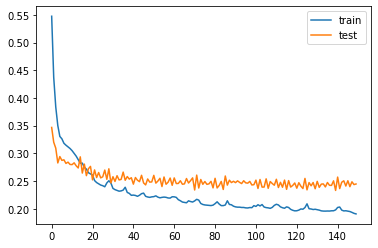

In [65]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(GRU(50, return_sequences=False))
model.add(Dense(train_y.shape[1], activation='relu'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [66]:
def predict(start_arr, dist):
    res = np.array(start_arr)[:,0:15]
    
    for i in range(dist):
        pred = model.predict(np.array([res[-n_hours:]])).reshape(n_predict,15)
        res = np.concatenate((res, pred))
    return res

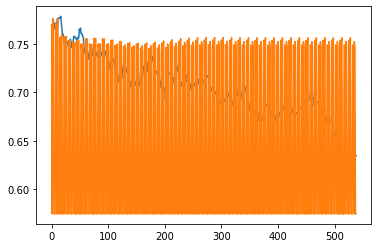

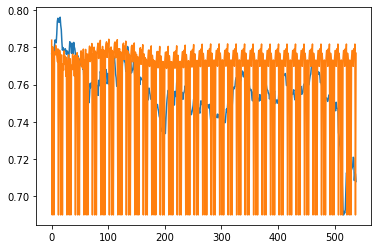

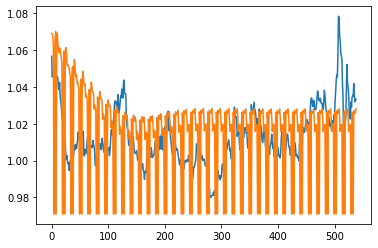

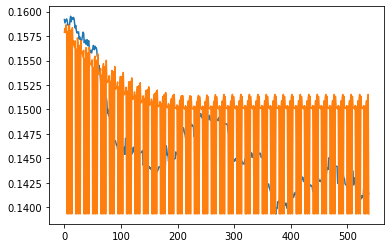

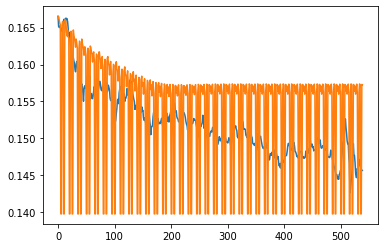

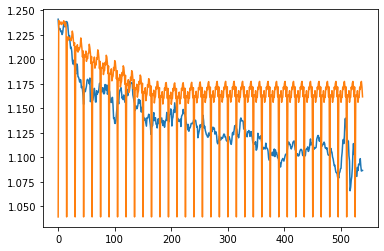

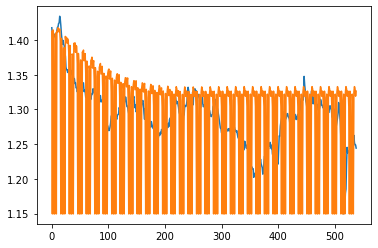

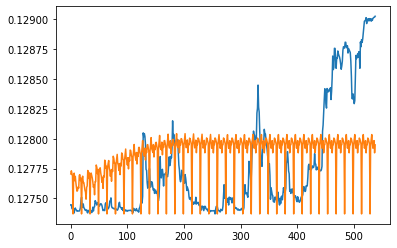

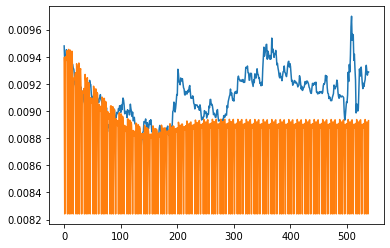

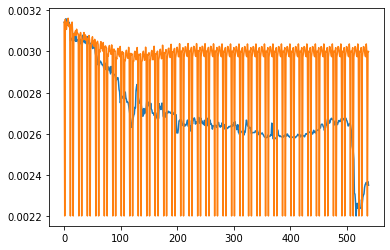

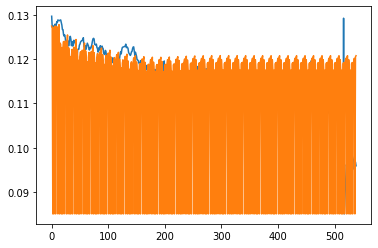

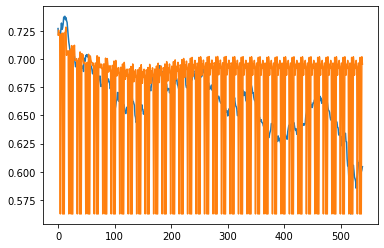

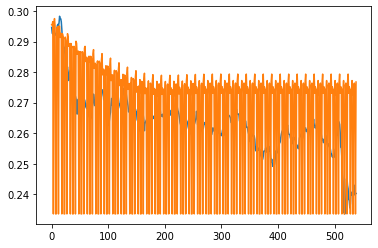

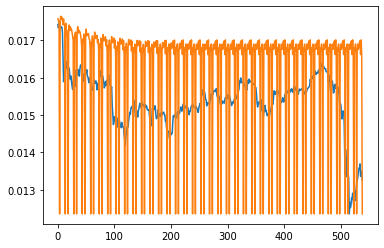

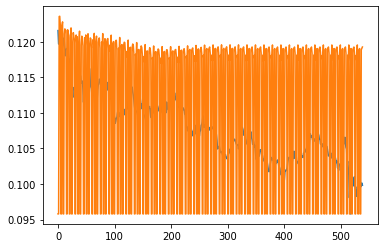

In [67]:
for i in range(new_data.values.shape[1]):
  plt.plot(scaler.inverse_transform(test_y[:,0:15])[:,i])
  plt.plot(scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])[:,i])
  plt.show()

In [26]:
train_y[:,0:15][-1]

array([0.89144015, 0.77353716, 0.83199215, 0.92659616, 0.9002433 ,
       0.90268946, 0.71561146, 0.31119537, 0.54248667, 0.817585  ,
       0.90381706, 0.8617122 , 0.91175246, 0.88240933, 0.89459085],
      dtype=float32)

In [27]:
train_y[:,15:][-1]

array([0.892221  , 0.76797295, 0.8648176 , 0.90996313, 0.9203243 ,
       0.9262829 , 0.72612   , 0.29449463, 0.58720064, 0.8411989 ,
       0.9175831 , 0.87207055, 0.9305136 , 0.8895395 , 0.90800834],
      dtype=float32)

In [28]:
test_y[:,0:15][0]

array([0.892221  , 0.76797295, 0.8648176 , 0.90996313, 0.9203243 ,
       0.9262829 , 0.72612   , 0.29449463, 0.58720064, 0.8411989 ,
       0.9175831 , 0.87207055, 0.9305136 , 0.8895395 , 0.90800834],
      dtype=float32)

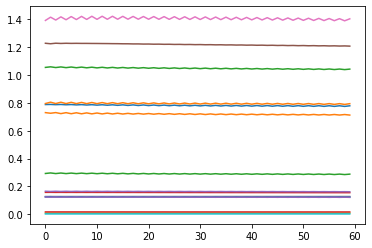

In [29]:
plt.plot(scaler.inverse_transform(predict(train_y, 30)[500:]))

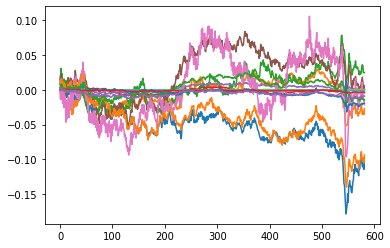

In [30]:
plt.plot(scaler.inverse_transform(test_y[:,0:15]) - scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)]))

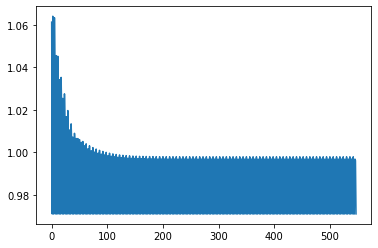

In [56]:
plt.plot(scaler.inverse_transform(predict(train_y, 600))[500:500+len(test_y),2])

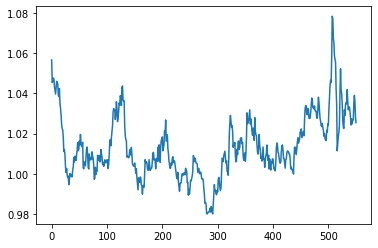

In [43]:
plt.plot(scaler.inverse_transform(test_y[:,0:15])[:,2])

In [33]:
predict(train_y, 10)[:500][-1]

array([0.89144015, 0.77353716, 0.83199215, 0.92659616, 0.9002433 ,
       0.90268946, 0.71561146, 0.31119537, 0.54248667, 0.817585  ,
       0.90381706, 0.8617122 , 0.91175246, 0.88240933, 0.89459085],
      dtype=float32)

In [34]:
test_y[0][:15]

array([0.892221  , 0.76797295, 0.8648176 , 0.90996313, 0.9203243 ,
       0.9262829 , 0.72612   , 0.29449463, 0.58720064, 0.8411989 ,
       0.9175831 , 0.87207055, 0.9305136 , 0.8895395 , 0.90800834],
      dtype=float32)

In [35]:
train_y[-1][15:]

array([0.892221  , 0.76797295, 0.8648176 , 0.90996313, 0.9203243 ,
       0.9262829 , 0.72612   , 0.29449463, 0.58720064, 0.8411989 ,
       0.9175831 , 0.87207055, 0.9305136 , 0.8895395 , 0.90800834],
      dtype=float32)